load env

In [1]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="../.env", override=True)

True

## Configuration

In [2]:
from pydantic import BaseModel, Field
from langsmith import Client

client = Client()


class AgentConfiguration(BaseModel):
    query_model: str = Field(
        default="openai/gpt-4o-mini",
        description="The language model used for processing and refining queries. Should be in the form: provider/model-name.",
    )
    response_model: str = Field(
        default="openai/gpt-4o-mini",
        description="The language model used for generating responses. Should be in the form: provider/model-name."
    )
    router_system_prompt: str = Field(
        default=(
            client.pull_prompt("langchain-ai/chat-langchain-router-prompt")
            .messages[0]
            .prompt.template
        ),
        description="The system prompt used for classifying user questions to route them to the correct node.",
    )
    more_info_system_prompt: str = Field(
        default=(
            client.pull_prompt("langchain-ai/chat-langchain-more-info-prompt")
            .messages[0]
            .prompt.template
        ),
        description="The system prompt used for asking for more information from the user."
    )
    general_system_prompt: str = Field(
        default=(
            client.pull_prompt("langchain-ai/chat-langchain-general-prompt")
            .messages[0]
            .prompt.template
        ),
        description="The system prompt used for responding to general questions.",
    )

    research_plan_system_prompt: str = Field(
        default=(
            client.pull_prompt("langchain-ai/chat-langchain-research-plan-prompt")
            .messages[0]
            .prompt.template
        ),
        description="The system prompt used for generating a research plan based on the user's question.",
    )

    response_system_prompt: str = Field(
        default=(
            client.pull_prompt("langchain-ai/chat-langchain-research-plan-prompt")
            .messages[0]
            .prompt.template
        ),
        description="The system prompt used for generating responses.",
    )

## State

In [4]:
import uuid
from typing import Any, Optional, Union, Literal
from langchain_core.documents import Document

def reduce_docs(
    existing: Optional[list[Document]],
    new: Union[
        list[Document],
        list[dict[str, Any]],
        list[str],
        str,
        Literal["delete"],
    ],
) -> list[Document]:
    """Reduce and process documents based on the input type.

    This function handles various input types and converts them into a sequence of Document objects.
    It also combines existing documents with the new one based on the document ID.

    Args:
        existing (Optional[Sequence[Document]]): The existing docs in the state, if any.
        new (Union[Sequence[Document], Sequence[dict[str, Any]], Sequence[str], str, Literal["delete"]]):
            The new input to process. Can be a sequence of Documents, dictionaries, strings, or a single string.
    """
    if new == "delete":
        return []

    existing_list = list(existing) if existing else []
    if isinstance(new, str):
        return existing_list + [
            Document(page_content=new, metadata={"uuid": str(uuid.uuid4())})
        ]

    new_list = []
    if isinstance(new, list):
        existing_ids = set(doc.metadata.get("uuid") for doc in existing_list)
        for item in new:
            if isinstance(item, str):
                item_id = str(uuid.uuid4())
                new_list.append(Document(page_content=item, metadata={"uuid": item_id}))
                existing_ids.add(item_id)

            elif isinstance(item, dict):
                metadata = item.get("metadata", {})
                item_id = metadata.get("uuid", str(uuid.uuid4()))

                if item_id not in existing_ids:
                    new_list.append(
                        Document(**item, metadata={**metadata, "uuid": item_id})
                    )
                    existing_ids.add(item_id)

            elif isinstance(item, Document):
                item_id = item.metadata.get("uuid")
                if item_id is None:
                    item_id = str(uuid.uuid4())
                    new_item = item.model_copy(update={"metadata": {"uuid": item_id}})
                else:
                    new_item = item

                if item_id not in existing_ids:
                    new_list.append(new_item)
                    existing_ids.add(item_id)


In [14]:
from pydantic import BaseModel, Field
from typing import Literal, Annotated
from langchain_core.messages import AnyMessage
from langchain_core.documents import Document
from langgraph.graph import add_messages

class Router(BaseModel):
    logic: str = Field(default="", description="The logic of the router.")
    type: Literal["more-info", "langchain", "general"] = Field(description="The type of the router.")


class InputState(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages] = Field(default_factory=list, description="Accumulated messages with unique IDs.")

class AgentState(InputState):
    router: Router = Field(default=Router(type="general", logic=""), description="Router classification of the user's query.")
    steps: list[str] = Field(default_factory=list, description="A list of steps in the research plan.")
    documents: Annotated[list[Document], reduce_docs] = Field(default_factory=list, description="Populated by the retriever. This is a list of documents that the agent can reference.")
    answer: str = Field(default="", description="Final answer. Useful for evaluations")
    query: str = Field(default="", description="The query of the user.")


class ResearcherState(BaseModel):
    question: str
    """A step in the research plan generated by the retriever agent."""
    queries: list[str] = Field(default_factory=list)
    """A list of search queries based on the question that the researcher generates."""
    documents: Annotated[list[Document], reduce_docs] = Field(default_factory=list)
    """Populated by the retriever. This is a list of documents that the agent can reference."""

## Tools

### Router

In [ ]:
import os
from langchain_core.language_models import BaseChatModel
from langchain_community.chat_models import ChatTongyi
from langchain.chat_models import init_chat_model
from langchain_core.runnables import RunnableConfig

def load_chat_model(fully_specified_name: str) -> tuple[BaseChatModel, str, str]:
    """Load a chat model from a fully specified name.

    Args:
        fully_specified_name (str): String in the format 'provider/model'.
    """
    if "/" in fully_specified_name:
        provider, name = fully_specified_name.split("/", maxsplit=1)
    else:
        provider = ""
        name = fully_specified_name

    model_kwargs = {"temperature": 0}
    if provider == "google_genai":
        # google doesn't support system message
        model_kwargs["convert_system_message_to_human"] = True
    if provider == "tongyi":
        # init_chat_model doesn't support tongyi
        return ChatTongyi(name=name, model_kwargs=model_kwargs), provider, name
    return (
        init_chat_model(name, model_provider=provider, **model_kwargs),
        provider,
        name,
    )

"""Route的目的是往state里面添加router"""
async def analyze_and_route_query(
    state: AgentState, *, config: RunnableConfig
) -> dict[str, Router]:
    """Analyze the user's query and determine the appropriate routing.

    This function uses a language model to classify the user's query and decide how to route it
    within the conversation flow.

    Args:
        state (AgentState): The current state of the agent, including conversation history.
        config (RunnableConfig): Configuration with the model used for query analysis.

    Returns:
        dict[str, Router]: A dictionary containing the 'router' key with the classification result (classification type and logic).
    """
    if state.router and state.router["logic"]: # for testing
        return {"router": state.router}
    configuration = AgentConfiguration.model_validate(config.get("configurable"))
    structured_output_kwargs = (
        {"method": "function_calling"} if "openai" in configuration.query_model else {}
    )
    llm, _, _ = load_chat_model(configuration.query_model)
    model = llm.with_structured_output(
        Router, **structured_output_kwargs
    )
    messages = [
        {"role": "system", "content": configuration.router_system_prompt}
    ] + state.messages
    response = cast(Router, await model.ainvoke(messages))
    return {"router": response}


"""根据上游产生的router决定下一步去哪个node"""
def route_query(
    state: AgentState,
) -> Literal["create_research_plan", "ask_for_more_info", "respond_to_general_query"]:
    """Determine the next step based on the query classification.

    Args:
        state (AgentState): The current state of the agent, including the router's classification.

    Returns:
        Literal["create_research_plan", "ask_for_more_info", "respond_to_general_query"]: The next step to take.

    Raises:
        ValueError: If an unknown router type is encountered.
    """
    _type = state.router["type"]
    if _type == "langchain":
        return "create_research_plan"
    elif _type == "more-info":
        return "ask_for_more_info"
    elif _type == "general":
        return "respond_to_general_query"
    else:
        raise ValueError(f"Unknown router type {_type}")

### More Info

In [ ]:
from langchain_core.messages import BaseMessage

"""如果router引导到这一步, 那么就要求询问更多信息"""
async def ask_for_more_info(
    state: AgentState, *, config: RunnableConfig
) -> dict[str, list[BaseMessage]]:
    """Generate a response asking the user for more information.

    This node is called when the router determines that more information is needed from the user.

    Args:
        state (AgentState): The current state of the agent, including conversation history and router logic.
        config (RunnableConfig): Configuration with the model used to respond.

    Returns:
        dict[str, list[str]]: A dictionary with a 'messages' key containing the generated response.
    """
    configuration = AgentConfiguration.model_validate(
        config.get("configurable")
    )
    model, _, _ = load_chat_model(configuration.query_model)
    system_prompt = configuration.more_info_system_prompt.format(
        logic=state.router["logic"]
    )
    messages = [{"role": "system", "content": system_prompt}] + state.messages
    response = await model.ainvoke(messages)
    return {"messages": [response]}

### General Question

In [23]:
async def respond_to_general_query(
    state: AgentState, *, config: RunnableConfig
) -> dict[str, list[BaseMessage]]:
    """Generate a response to a general query not related to LangChain.

    This node is called when the router classifies the query as a general question.

    Args:
        state (AgentState): The current state of the agent, including conversation history and router logic.
        config (RunnableConfig): Configuration with the model used to respond.

    Returns:
        dict[str, list[str]]: A dictionary with a 'messages' key containing the generated response.
    """
    configuration = AgentConfiguration.model_validate(
        config.get("configurable")
    )
    model, _, _ = load_chat_model(configuration.query_model)
    system_prompt = configuration.general_system_prompt.format(
        logic=state.router["logic"]
    )
    messages = [{"role": "system", "content": system_prompt}] + state.messages
    response = await model.ainvoke(messages)
    return {"messages": [response]}

### Research Plan

In [ ]:
async def create_research_plan(
    state: AgentState, *, config: RunnableConfig
) -> dict[str, list[str]]:
    """Create a step-by-step research plan for answering a LangChain-related query.

    Args:
        state (AgentState): The current state of the agent, including conversation history.
        config (RunnableConfig): Configuration with the model used to generate the plan.

    Returns:
        dict[str, list[str]]: A dictionary with a 'steps' key containing the list of research steps.
    """

    class Plan(TypedDict):
        """Generate research plan."""

        steps: list[str]

    configuration = AgentConfiguration.model_validate(
        config.get("configurable")
    )   
    structured_output_kwargs = (
        {"method": "function_calling"} if "openai" in configuration.query_model else {}
    )
    model, _, _ = load_chat_model(configuration.query_model).with_structured_output(
        Plan, **structured_output_kwargs
    )
    messages = [
        {"role": "system", "content": configuration.research_plan_system_prompt}
    ] + state.messages
    response = cast(
        Plan, await model.ainvoke(messages, {"tags": ["langsmith:nostream"]})
    )
    return {
        "steps": response["steps"],
        "documents": "delete",
        "query": state.messages[-1].content, # 后续没用到
    }


async def conduct_research(state: AgentState) -> dict[str, Any]:
    """Execute the first step of the research plan.

    This function takes the first step from the research plan and uses it to conduct research.

    Args:
        state (AgentState): The current state of the agent, including the research plan steps.

    Returns:
        dict[str, list[str]]: A dictionary with 'documents' containing the research results and
                              'steps' containing the remaining research steps.

    Behavior:
        - Invokes the researcher_graph with the first step of the research plan.
        - Updates the state with the retrieved documents and removes the completed step.
    """
    result = await researcher_graph.ainvoke({"question": state.steps[0]})
    return {"documents": result["documents"], "steps": state.steps[1:]} # 每执行一次就把状态成员steps已经执行完的step删除


def check_finished(state: AgentState) -> Literal["respond", "conduct_research"]:
    """Determine if the research process is complete or if more research is needed.

    This function checks if there are any remaining steps in the research plan:
        - If there are, route back to the `conduct_research` node
        - Otherwise, route to the `respond` node

    Args:
        state (AgentState): The current state of the agent, including the remaining research steps.

    Returns:
        Literal["respond", "conduct_research"]: The next step to take based on whether research is complete.
    """
    if len(state.steps or []) > 0:
        return "conduct_research" # steps 不为空 说明还有没执行完的step
    else:
        return "respond" # 为空说明执行完毕

### Final Response

In [17]:
async def respond(
    state: AgentState, *, config: RunnableConfig
) -> dict[str, list[BaseMessage]]:
    """Generate a final response to the user's query based on the conducted research.

    This function formulates a comprehensive answer using the conversation history and the documents retrieved by the researcher.

    Args:
        state (AgentState): The current state of the agent, including retrieved documents and conversation history.
        config (RunnableConfig): Configuration with the model used to respond.

    Returns:
        dict[str, list[str]]: A dictionary with a 'messages' key containing the generated response.
    """
    configuration = AgentConfiguration.model_validate(
        config.get("configurable")
    )
    model, _, _ = load_chat_model(configuration.response_model)
    # TODO: add a re-ranker here
    top_k = 20
    context = format_docs(state.documents[:top_k])
    prompt = configuration.response_system_prompt.format(context=context)
    messages = [{"role": "system", "content": prompt}] + state.messages
    response = await model.ainvoke(messages)
    return {"messages": [response], "answer": response.content}

## Graph

In [27]:
from langgraph.graph import END, START, StateGraph


builder = StateGraph(AgentState, input_schema=InputState, config_schema=AgentConfiguration)
builder.add_node(analyze_and_route_query)
builder.add_node(ask_for_more_info)
builder.add_node(respond_to_general_query)
builder.add_node(create_research_plan)
builder.add_node(conduct_research)
builder.add_node(respond)


builder.add_edge(START, "analyze_and_route_query")
builder.add_conditional_edges("analyze_and_route_query", path=route_query)
builder.add_edge("respond_to_general_query", END)
builder.add_edge("ask_for_more_info", "analyze_and_route_query")
builder.add_edge("create_research_plan", "conduct_research")
builder.add_conditional_edges("conduct_research", check_finished)
builder.add_edge("respond", END)

# Compile into a graph object that you can invoke and deploy.
graph = builder.compile()
graph.name = "RetrievalGraph"

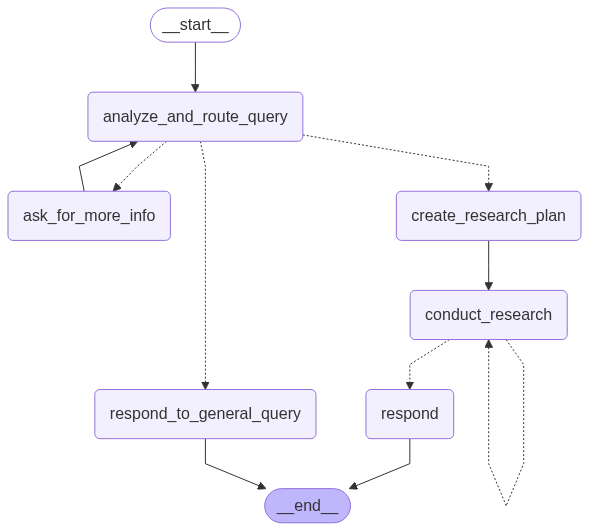

In [28]:
# draw graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))